In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/tf/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.losses import mean_squared_error
from sklearn import metrics

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# run eagerly should be set to true. 
tf.config.run_functions_eagerly(True)

import copy


warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()



def create_dataframe_from_query(query,column_list):
    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=column_list
    )

    return indicators_raw_df


def wmae_loss(y_true, y_pred):
    
    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    l = 1.5
    
    diff = y_true[:,0] - y_pred[:,0]
    
    w_true = step_function(y_true[:, 1])
    w_pred = step_function(calculate_gain(y_pred[:, 1]))
    
    # Weighted mean absolute error
    threshold = w_true * diff
    wae = step_function(threshold) * ((l + abs(w_true - w_pred)) * abs(diff)) \
            + (1 - step_function(threshold)) * ((1/l) * abs(diff))
    wmae = sum(wae) / wae.shape[0]
    
    return wmae

def wmse_loss(y_true, y_pred):
    
    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    l = 1.5

    # -1.0 <= absolute_diff <= 1.0
    absolute_diff = y_true[:,0] - y_pred[:,0]
    
    # 1.0 <= squared_diff
    squared_diff = step_function(absolute_diff) * (absolute_diff+2)**2 \
            + (1 - step_function(absolute_diff)) * (absolute_diff-2)**2
    
    w_true = step_function(y_true[:, 1])
    w_pred = step_function(calculate_gain(y_pred[:, 1]))
    
    # Weighted mean squared error
    threshold = w_true * absolute_diff
    wse = step_function(threshold) * ((l + abs(w_true - w_pred)) * abs(squared_diff)) \
            + (1 - step_function(threshold)) * ((1/l) * abs(squared_diff))
    wmse = sum(wse) / wse.shape[0]
    
    return wmse


def f1_metric(true, pred):

    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    g_true = step_function(true[:, 1])
    g_pred = step_function(calculate_gain(pred[:, 0]))

    ground_positives = K.cast(K.sum(g_true, axis=0), "float") + K.epsilon()       # = TP + FN
    pred_positives = K.cast(K.sum(g_pred, axis=0), "float") + K.epsilon()         # = TP + FP
    true_positives = K.cast(K.sum(g_true * g_pred, axis=0), "float") + K.epsilon()  # = TP
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #still with shape (4,)

    return f1

2023-11-11 16:24:25.829919: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-11 16:24:25.854770: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-11 16:24:26.701645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 16:24:26.705452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 16:24:26.705570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
########################
# Create BTC_USDT featrue dataframe
########################
query = f"""
    with 
    ohlcv_minute_data as
    (
        select 
            open,
            high,
            low,
            close,
            amount as total_volume,
            quantity as total_quantity,
            tradeCount as total_trade_count,
            date_trunc('minute',ts_create_utc) as ts
        from 
            hive.crypto_raw.candles_minute 
        where 
            id = 'BTC_USDT'
    ),
    buy_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as buy_trade_count,
            sum(amount) as sum_buy_taker_amount,
            sum(quantity)  as sum_buy_taker_quantity,
            avg(price) as avg_buy_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'buy'
        group by
            1
    ), 
    sell_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as sell_trade_count,
            sum(amount) as sum_sell_taker_amount,
            sum(quantity) as sum_sell_taker_quantity,
            avg(price) as avg_sell_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'sell'
        group by
            1
    )
    select
        a.open as open,
        a.high as high,
        a.low as low,
        a.close as close,
        a.total_volume as total_volume,
        a.total_quantity as total_quantity,
        a.total_trade_count as total_trade_count,
        b.buy_trade_count as buy_trade_count,
        b.sum_buy_taker_amount as sum_buy_taker_amount,
        b.sum_buy_taker_quantity as sum_buy_taker_quantity,
        b.avg_buy_trade_price as avg_buy_trade_price,
        c.sell_trade_count as sell_trade_count,
        c.sum_sell_taker_amount as sum_sell_taker_amount,
        c.sum_sell_taker_quantity as sum_sell_taker_quantity,
        c.avg_sell_trade_price as avg_sell_trade_price,
        a.ts as ts
    from
        ohlcv_minute_data as a
    left join
        buy_tacker_market_data as b
    on a.ts = b.ts
    left join
        sell_tacker_market_data as c
    on 
        a.ts = c.ts
    where 
        b.buy_trade_count is not null
        and c.sell_trade_count is not null
    order by
        a.ts
"""

column_list = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price',
    'ts'
]
btc_raw_df = create_dataframe_from_query(query,column_list)
btc_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts
93551,36609.49,36620.24,36601.02,36619.90,107610.70,2.939085,75,35,47552.1800,1.298780,36613.605,40,60058.527000,1.640305,36614.13,2023-11-10 10:37:00
93552,36619.14,36628.87,36611.66,36621.26,110156.95,3.007775,79,38,59794.5900,1.632677,36623.758,41,50362.360000,1.375098,36623.91,2023-11-10 10:38:00
93553,36621.26,36630.66,36609.78,36620.83,102758.72,2.805888,74,37,48875.0620,1.334560,36622.960,37,53883.664000,1.471328,36622.10,2023-11-10 10:39:00
93554,36619.25,36630.66,36619.17,36621.18,20554.95,0.561305,14,4,5730.0205,0.156475,36622.203,10,14824.932000,0.404830,36620.09,2023-11-10 10:40:00
93555,36608.68,36608.68,36538.55,36538.55,1601.73,0.043827,11,9,1595.0424,0.043644,36546.074,2,6.696044,0.000183,36579.34,2023-11-10 10:46:00


In [3]:
###########################################################
# Caluculate close price gain from past close price.
###########################################################

p1_close_price = btc_raw_df["close"].shift(1)
p3_close_price = btc_raw_df["close"].shift(3)
p5_close_price = btc_raw_df["close"].shift(5)
p10_close_price = btc_raw_df["close"].shift(10)
p30_close_price = btc_raw_df["close"].shift(30)
p60_close_price = btc_raw_df["close"].shift(60)

btc_raw_df["p1_gain"] = btc_raw_df["close"] / p1_close_price - 1.0
btc_raw_df["p3_gain"] = btc_raw_df["close"] / p3_close_price - 1.0
btc_raw_df["p5_gain"] = btc_raw_df["close"] / p5_close_price - 1.0
btc_raw_df["p10_gain"] = btc_raw_df["close"] / p10_close_price - 1.0
btc_raw_df["p30_gain"] = btc_raw_df["close"] / p30_close_price - 1.0
btc_raw_df["p60_gain"] = btc_raw_df["close"] / p60_close_price - 1.0

btc_raw_df

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,...,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain,p3_gain,p5_gain,p10_gain,p30_gain,p60_gain
1,25824.44,25831.18,25819.53,25825.24,95769.52,3.708438,72,41,53700.4500,2.079428,...,42069.074000,1.629010,25824.785,2023-09-02 12:11:00,NaN,NaN,NaN,NaN,NaN,NaN
2,25825.69,25831.18,25824.56,25825.60,84266.64,3.262884,61,24,28694.2970,1.111076,...,55572.350000,2.151808,25825.865,2023-09-02 12:12:00,0.000014,NaN,NaN,NaN,NaN,NaN
3,25825.46,25826.37,25820.69,25825.53,75424.89,2.920544,56,29,36727.9600,1.422152,...,38696.934000,1.498392,25825.506,2023-09-02 12:13:00,-0.000003,NaN,NaN,NaN,NaN,NaN
4,25825.41,25830.08,25824.86,25826.63,64327.65,2.490819,51,24,27203.9940,1.053362,...,37123.660000,1.437457,25825.879,2023-09-02 12:14:00,0.000043,0.000054,NaN,NaN,NaN,NaN
5,25826.25,25831.17,25825.55,25826.26,66004.63,2.555701,44,24,33439.0300,1.294760,...,32565.605000,1.260941,25826.398,2023-09-02 12:15:00,-0.000014,0.000026,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93551,36609.49,36620.24,36601.02,36619.90,107610.70,2.939085,75,35,47552.1800,1.298780,...,60058.527000,1.640305,36614.130,2023-11-10 10:37:00,0.000295,0.000718,0.000582,0.001257,0.001661,0.003637
93552,36619.14,36628.87,36611.66,36621.26,110156.95,3.007775,79,38,59794.5900,1.632677,...,50362.360000,1.375098,36623.910,2023-11-10 10:38:00,0.000037,0.000729,0.000875,0.001461,0.001733,0.003585
93553,36621.26,36630.66,36609.78,36620.83,102758.72,2.805888,74,37,48875.0620,1.334560,...,53883.664000,1.471328,36622.100,2023-11-10 10:39:00,-0.000012,0.000321,0.000744,0.001276,0.001683,0.003031
93554,36619.25,36630.66,36619.17,36621.18,20554.95,0.561305,14,4,5730.0205,0.156475,...,14824.932000,0.404830,36620.090,2023-11-10 10:40:00,0.000010,0.000035,0.000726,0.001452,0.002095,0.003221


In [4]:
#########################################
# Sumurate past data
#########################################

# total_volume
total_volume_df = pd.DataFrame(btc_raw_df['total_volume'])
for i in range(60):
    total_volume_df[f'p{i}_total_volume'] = btc_raw_df['total_volume'].shift(i)
    
total_volume_3_min_columns = [f'p{i}_total_volume' for i in range(3)]
btc_raw_df['total_volume_3_min'] = total_volume_df[total_volume_3_min_columns].sum(axis=1)

total_volume_5_min_columns = [f'p{i}_total_volume' for i in range(5)]
btc_raw_df['total_volume_5_min'] = total_volume_df[total_volume_5_min_columns].sum(axis=1)

total_volume_10_min_columns = [f'p{i}_total_volume' for i in range(10)]
btc_raw_df['total_volume_10_min'] = total_volume_df[total_volume_10_min_columns].sum(axis=1)

total_volume_30_min_columns = [f'p{i}_total_volume' for i in range(30)]
btc_raw_df['total_volume_30_min'] = total_volume_df[total_volume_30_min_columns].sum(axis=1)

total_volume_60_min_columns = [f'p{i}_total_volume' for i in range(60)]
btc_raw_df['total_volume_60_min'] = total_volume_df[total_volume_60_min_columns].sum(axis=1)

btc_raw_df[[
    'total_volume',
    'total_volume_3_min',
    'total_volume_5_min',
    'total_volume_10_min',
    'total_volume_30_min',
    'total_volume_60_min'
]]

,total_volume,total_volume_3_min,total_volume_5_min,total_volume_10_min,total_volume_30_min,total_volume_60_min
1,95769.52,95769.52,95769.52,95769.52,95769.52,95769.52
2,84266.64,180036.16,180036.16,180036.16,180036.16,180036.16
3,75424.89,255461.05,255461.05,255461.05,255461.05,255461.05
4,64327.65,224019.18,319788.70,319788.70,319788.70,319788.70
5,66004.63,205757.17,385793.33,385793.33,385793.33,385793.33
...,...,...,...,...,...,...
93551,107610.70,366402.38,626352.78,1255480.52,3438685.80,4286737.98
93552,110156.95,350555.31,604117.85,1200966.49,3422000.79,4396331.72
93553,102758.72,320526.37,579318.05,1165500.59,3418263.73,4486806.84
93554,20554.95,233470.62,473868.98,1061774.35,3334469.85,4505291.81


In [5]:
# total_trade_count
total_trade_count_df = pd.DataFrame(btc_raw_df['total_trade_count'])
for i in range(60):
    total_trade_count_df[f'p{i}_total_trade_count'] = btc_raw_df['total_trade_count'].shift(i)
    
total_trade_count_3_min_columns = [f'p{i}_total_trade_count' for i in range(3)]
btc_raw_df['total_trade_count_3_min'] = total_trade_count_df[total_trade_count_3_min_columns].sum(axis=1)

total_trade_count_5_min_columns = [f'p{i}_total_trade_count' for i in range(5)]
btc_raw_df['total_trade_count_5_min'] = total_trade_count_df[total_trade_count_5_min_columns].sum(axis=1)

total_trade_count_10_min_columns = [f'p{i}_total_trade_count' for i in range(10)]
btc_raw_df['total_trade_count_10_min'] = total_trade_count_df[total_trade_count_10_min_columns].sum(axis=1)

total_trade_count_30_min_columns = [f'p{i}_total_trade_count' for i in range(30)]
btc_raw_df['total_trade_count_30_min'] = total_trade_count_df[total_trade_count_30_min_columns].sum(axis=1)

total_trade_count_60_min_columns = [f'p{i}_total_trade_count' for i in range(60)]
btc_raw_df['total_trade_count_60_min'] = total_trade_count_df[total_trade_count_60_min_columns].sum(axis=1)

btc_raw_df[[
    'total_trade_count',
    'total_trade_count_3_min',
    'total_trade_count_5_min',
    'total_trade_count_10_min',
    'total_trade_count_30_min',
    'total_trade_count_60_min'
]]

,total_trade_count,total_trade_count_3_min,total_trade_count_5_min,total_trade_count_10_min,total_trade_count_30_min,total_trade_count_60_min
1,72,72.0,72.0,72.0,72.0,72.0
2,61,133.0,133.0,133.0,133.0,133.0
3,56,189.0,189.0,189.0,189.0,189.0
4,51,168.0,240.0,240.0,240.0,240.0
5,44,151.0,284.0,284.0,284.0,284.0
...,...,...,...,...,...,...
93551,75,265.0,444.0,864.0,2452.0,3199.0
93552,79,248.0,434.0,846.0,2432.0,3271.0
93553,74,228.0,418.0,830.0,2407.0,3336.0
93554,14,167.0,336.0,758.0,2329.0,3347.0


In [6]:
# buy_trade_count
buy_trade_count_df = pd.DataFrame(btc_raw_df['buy_trade_count'])
for i in range(60):
    buy_trade_count_df[f'p{i}_buy_trade_count'] = btc_raw_df['buy_trade_count'].shift(i)
    
buy_trade_count_3_min_columns = [f'p{i}_buy_trade_count' for i in range(3)]
btc_raw_df['buy_trade_count_3_min'] = buy_trade_count_df[buy_trade_count_3_min_columns].sum(axis=1)

buy_trade_count_5_min_columns = [f'p{i}_buy_trade_count' for i in range(5)]
btc_raw_df['buy_trade_count_5_min'] = buy_trade_count_df[buy_trade_count_5_min_columns].sum(axis=1)

buy_trade_count_10_min_columns = [f'p{i}_buy_trade_count' for i in range(10)]
btc_raw_df['buy_trade_count_10_min'] = buy_trade_count_df[buy_trade_count_10_min_columns].sum(axis=1)

buy_trade_count_30_min_columns = [f'p{i}_buy_trade_count' for i in range(30)]
btc_raw_df['buy_trade_count_30_min'] = buy_trade_count_df[buy_trade_count_30_min_columns].sum(axis=1)

buy_trade_count_60_min_columns = [f'p{i}_buy_trade_count' for i in range(60)]
btc_raw_df['buy_trade_count_60_min'] = buy_trade_count_df[buy_trade_count_60_min_columns].sum(axis=1)

btc_raw_df[[
    'buy_trade_count',
    'buy_trade_count_3_min',
    'buy_trade_count_5_min',
    'buy_trade_count_10_min',
    'buy_trade_count_30_min',
    'buy_trade_count_60_min'
]]

,buy_trade_count,buy_trade_count_3_min,buy_trade_count_5_min,buy_trade_count_10_min,buy_trade_count_30_min,buy_trade_count_60_min
1,41,41.0,41.0,41.0,41.0,41.0
2,24,65.0,65.0,65.0,65.0,65.0
3,29,94.0,94.0,94.0,94.0,94.0
4,24,77.0,118.0,118.0,118.0,118.0
5,24,77.0,142.0,142.0,142.0,142.0
...,...,...,...,...,...,...
93551,35,123.0,230.0,435.0,1262.0,1627.0
93552,38,115.0,212.0,428.0,1242.0,1663.0
93553,37,110.0,198.0,422.0,1211.0,1692.0
93554,4,79.0,156.0,390.0,1164.0,1695.0


In [7]:
# sum_buy_taker_amount
sum_buy_taker_amount_df = pd.DataFrame(btc_raw_df['sum_buy_taker_amount'])
for i in range(60):
    sum_buy_taker_amount_df[f'p{i}_sum_buy_taker_amount'] = btc_raw_df['sum_buy_taker_amount'].shift(i)
    
sum_buy_taker_amount_3_min_columns = [f'p{i}_sum_buy_taker_amount' for i in range(3)]
btc_raw_df['sum_buy_taker_amount_3_min'] = sum_buy_taker_amount_df[sum_buy_taker_amount_3_min_columns].sum(axis=1)

sum_buy_taker_amount_5_min_columns = [f'p{i}_sum_buy_taker_amount' for i in range(5)]
btc_raw_df['sum_buy_taker_amount_5_min'] = sum_buy_taker_amount_df[sum_buy_taker_amount_5_min_columns].sum(axis=1)

sum_buy_taker_amount_10_min_columns = [f'p{i}_sum_buy_taker_amount' for i in range(10)]
btc_raw_df['sum_buy_taker_amount_10_min'] = sum_buy_taker_amount_df[sum_buy_taker_amount_10_min_columns].sum(axis=1)

sum_buy_taker_amount_30_min_columns = [f'p{i}_sum_buy_taker_amount' for i in range(30)]
btc_raw_df['sum_buy_taker_amount_30_min'] = sum_buy_taker_amount_df[sum_buy_taker_amount_30_min_columns].sum(axis=1)

sum_buy_taker_amount_60_min_columns = [f'p{i}_sum_buy_taker_amount' for i in range(60)]
btc_raw_df['sum_buy_taker_amount_60_min'] = sum_buy_taker_amount_df[sum_buy_taker_amount_60_min_columns].sum(axis=1)

btc_raw_df[[
    'sum_buy_taker_amount',
    'sum_buy_taker_amount_3_min',
    'sum_buy_taker_amount_5_min',
    'sum_buy_taker_amount_10_min',
    'sum_buy_taker_amount_30_min',
    'sum_buy_taker_amount_60_min'
]]

,sum_buy_taker_amount,sum_buy_taker_amount_3_min,sum_buy_taker_amount_5_min,sum_buy_taker_amount_10_min,sum_buy_taker_amount_30_min,sum_buy_taker_amount_60_min
1,53700.4500,53700.4500,53700.4500,53700.4500,5.370045e+04,5.370045e+04
2,28694.2970,82394.7470,82394.7470,82394.7470,8.239475e+04,8.239475e+04
3,36727.9600,119122.7070,119122.7070,119122.7070,1.191227e+05,1.191227e+05
4,27203.9940,92626.2510,146326.7010,146326.7010,1.463267e+05,1.463267e+05
5,33439.0300,97370.9840,179765.7310,179765.7310,1.797657e+05,1.797657e+05
...,...,...,...,...,...,...
93551,47552.1800,166027.2830,308743.2010,588202.8810,1.653564e+06,2.067637e+06
93552,59794.5900,163288.3830,289145.3810,582169.9110,1.641077e+06,2.127194e+06
93553,48875.0620,156221.8320,274696.9350,571438.7700,1.618062e+06,2.163929e+06
93554,5730.0205,114399.6725,217893.4655,522944.5505,1.574329e+06,2.169427e+06


In [8]:
# sell_trade_count
sell_trade_count_df = pd.DataFrame(btc_raw_df['sell_trade_count'])
for i in range(60):
    sell_trade_count_df[f'p{i}_sell_trade_count'] = btc_raw_df['sell_trade_count'].shift(i)
    
sell_trade_count_3_min_columns = [f'p{i}_sell_trade_count' for i in range(3)]
btc_raw_df['sell_trade_count_3_min'] = sell_trade_count_df[sell_trade_count_3_min_columns].sum(axis=1)

sell_trade_count_5_min_columns = [f'p{i}_sell_trade_count' for i in range(5)]
btc_raw_df['sell_trade_count_5_min'] = sell_trade_count_df[sell_trade_count_5_min_columns].sum(axis=1)

sell_trade_count_10_min_columns = [f'p{i}_sell_trade_count' for i in range(10)]
btc_raw_df['sell_trade_count_10_min'] = sell_trade_count_df[sell_trade_count_10_min_columns].sum(axis=1)

sell_trade_count_30_min_columns = [f'p{i}_sell_trade_count' for i in range(30)]
btc_raw_df['sell_trade_count_30_min'] = sell_trade_count_df[sell_trade_count_30_min_columns].sum(axis=1)

sell_trade_count_60_min_columns = [f'p{i}_sell_trade_count' for i in range(60)]
btc_raw_df['sell_trade_count_60_min'] = sell_trade_count_df[sell_trade_count_60_min_columns].sum(axis=1)

btc_raw_df[[
    'sell_trade_count',
    'sell_trade_count_3_min',
    'sell_trade_count_5_min',
    'sell_trade_count_10_min',
    'sell_trade_count_30_min',
    'sell_trade_count_60_min'
]]

,sell_trade_count,sell_trade_count_3_min,sell_trade_count_5_min,sell_trade_count_10_min,sell_trade_count_30_min,sell_trade_count_60_min
1,31,31.0,31.0,31.0,31.0,31.0
2,37,68.0,68.0,68.0,68.0,68.0
3,27,95.0,95.0,95.0,95.0,95.0
4,27,91.0,122.0,122.0,122.0,122.0
5,20,74.0,142.0,142.0,142.0,142.0
...,...,...,...,...,...,...
93551,40,142.0,214.0,429.0,1190.0,1571.0
93552,41,133.0,222.0,418.0,1190.0,1607.0
93553,37,118.0,220.0,408.0,1196.0,1643.0
93554,10,88.0,180.0,368.0,1165.0,1651.0


In [9]:
# sum_sell_taker_amount
sum_sell_taker_amount_df = pd.DataFrame(btc_raw_df['sum_sell_taker_amount'])
for i in range(60):
    sum_sell_taker_amount_df[f'p{i}_sum_sell_taker_amount'] = btc_raw_df['sum_sell_taker_amount'].shift(i)
    
sum_sell_taker_amount_3_min_columns = [f'p{i}_sum_sell_taker_amount' for i in range(3)]
btc_raw_df['sum_sell_taker_amount_3_min'] = sum_sell_taker_amount_df[sum_sell_taker_amount_3_min_columns].sum(axis=1)

sum_sell_taker_amount_5_min_columns = [f'p{i}_sum_sell_taker_amount' for i in range(5)]
btc_raw_df['sum_sell_taker_amount_5_min'] = sum_sell_taker_amount_df[sum_sell_taker_amount_5_min_columns].sum(axis=1)

sum_sell_taker_amount_10_min_columns = [f'p{i}_sum_sell_taker_amount' for i in range(10)]
btc_raw_df['sum_sell_taker_amount_10_min'] = sum_sell_taker_amount_df[sum_sell_taker_amount_10_min_columns].sum(axis=1)

sum_sell_taker_amount_30_min_columns = [f'p{i}_sum_sell_taker_amount' for i in range(30)]
btc_raw_df['sum_sell_taker_amount_30_min'] = sum_sell_taker_amount_df[sum_sell_taker_amount_30_min_columns].sum(axis=1)

sum_sell_taker_amount_60_min_columns = [f'p{i}_sum_sell_taker_amount' for i in range(60)]
btc_raw_df['sum_sell_taker_amount_60_min'] = sum_sell_taker_amount_df[sum_sell_taker_amount_60_min_columns].sum(axis=1)

btc_raw_df[[
    'sum_sell_taker_amount',
    'sum_sell_taker_amount_3_min',
    'sum_sell_taker_amount_5_min',
    'sum_sell_taker_amount_10_min',
    'sum_sell_taker_amount_30_min',
    'sum_sell_taker_amount_60_min'
]]

,sum_sell_taker_amount,sum_sell_taker_amount_3_min,sum_sell_taker_amount_5_min,sum_sell_taker_amount_10_min,sum_sell_taker_amount_30_min,sum_sell_taker_amount_60_min
1,42069.074000,42069.074000,42069.074000,42069.074000,4.206907e+04,4.206907e+04
2,55572.350000,97641.424000,97641.424000,97641.424000,9.764142e+04,9.764142e+04
3,38696.934000,136338.358000,136338.358000,136338.358000,1.363384e+05,1.363384e+05
4,37123.660000,131392.944000,173462.018000,173462.018000,1.734620e+05,1.734620e+05
5,32565.605000,108386.199000,206027.623000,206027.623000,2.060276e+05,2.060276e+05
...,...,...,...,...,...,...
93551,60058.527000,200375.122000,317609.611000,667277.699000,1.785121e+06,2.218101e+06
93552,50362.360000,187266.942000,314972.498000,618796.639000,1.780924e+06,2.268138e+06
93553,53883.664000,164304.551000,304621.146000,594061.873000,1.800202e+06,2.321878e+06
93554,14824.932000,119070.956000,255975.538000,538829.845000,1.760141e+06,2.334866e+06


In [10]:
####################################
# Create Dataset with target value
####################################
predicting_points = 1
btc_df_with_target = btc_raw_df
target_column_to_predict = 'close'
future_close = btc_raw_df[target_column_to_predict].shift(-predicting_points)
btc_df_with_target['future_close'] = future_close
btc_df_with_target.tail(10)

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,...,sell_trade_count_5_min,sell_trade_count_10_min,sell_trade_count_30_min,sell_trade_count_60_min,sum_sell_taker_amount_3_min,sum_sell_taker_amount_5_min,sum_sell_taker_amount_10_min,sum_sell_taker_amount_30_min,sum_sell_taker_amount_60_min,future_close
93546,36588.81,36605.80,36576.90,36598.59,127524.66,3.484980,89,43,56838.5600,1.553277,...,215.0,409.0,1194.0,1374.0,172206.238000,349668.088000,625558.430000,1.762064e+06,1.903714e+06,36589.25
93547,36598.73,36598.73,36573.96,36589.25,132391.88,3.618292,89,56,79392.4100,2.169785,...,196.0,406.0,1190.0,1404.0,155148.751000,303824.141000,633922.283000,1.767663e+06,1.956650e+06,36593.62
93548,36588.61,36601.15,36585.07,36593.62,127558.52,3.486159,90,51,63323.5080,1.730605,...,188.0,412.0,1173.0,1438.0,187920.589000,289440.727000,651935.451000,1.751505e+06,2.018988e+06,36594.60
93549,36593.80,36598.49,36580.47,36594.60,126004.02,3.443281,96,46,62533.4900,1.708794,...,188.0,416.0,1169.0,1484.0,180705.029000,282854.307000,645774.841000,1.741915e+06,2.081700e+06,36609.09
93550,36593.54,36609.13,36588.61,36609.09,132787.66,3.627791,94,42,55941.6130,1.528340,...,220.0,429.0,1186.0,1533.0,204551.611000,328237.184000,666841.176000,1.780931e+06,2.158118e+06,36619.90
93551,36609.49,36620.24,36601.02,36619.90,107610.70,2.939085,75,35,47552.1800,1.298780,...,214.0,429.0,1190.0,1571.0,200375.122000,317609.611000,667277.699000,1.785121e+06,2.218101e+06,36621.26
93552,36619.14,36628.87,36611.66,36621.26,110156.95,3.007775,79,38,59794.5900,1.632677,...,222.0,418.0,1190.0,1607.0,187266.942000,314972.498000,618796.639000,1.780924e+06,2.268138e+06,36620.83
93553,36621.26,36630.66,36609.78,36620.83,102758.72,2.805888,74,37,48875.0620,1.334560,...,220.0,408.0,1196.0,1643.0,164304.551000,304621.146000,594061.873000,1.800202e+06,2.321878e+06,36621.18
93554,36619.25,36630.66,36619.17,36621.18,20554.95,0.561305,14,4,5730.0205,0.156475,...,180.0,368.0,1165.0,1651.0,119070.956000,255975.538000,538829.845000,1.760141e+06,2.334866e+06,36538.55
93555,36608.68,36608.68,36538.55,36538.55,1601.73,0.043827,11,9,1595.0424,0.043644,...,130.0,350.0,1125.0,1649.0,68715.292044,179136.179044,507373.363044,1.703840e+06,2.333607e+06,NaN


In [11]:
# Check if the target value is defined as the future close value.
btc_df_with_target[['close','p1_gain','future_close']].tail(10)

,close,p1_gain,future_close
93546,36598.59,0.000231,36589.25
93547,36589.25,-0.000255,36593.62
93548,36593.62,0.000119,36594.60
93549,36594.60,0.000027,36609.09
93550,36609.09,0.000396,36619.90
93551,36619.90,0.000295,36621.26
93552,36621.26,0.000037,36620.83
93553,36620.83,-0.000012,36621.18
93554,36621.18,0.000010,36538.55
93555,36538.55,-0.002256,NaN


In [12]:
btc_df_with_target.describe()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,...,sell_trade_count_5_min,sell_trade_count_10_min,sell_trade_count_30_min,sell_trade_count_60_min,sum_sell_taker_amount_3_min,sum_sell_taker_amount_5_min,sum_sell_taker_amount_10_min,sum_sell_taker_amount_30_min,sum_sell_taker_amount_60_min,future_close
count,93555.000000,93555.000000,93555.000000,93555.000000,93555.000000,93555.000000,93555.000000,93555.000000,93555.000000,93555.000000,...,93555.000000,93555.000000,93555.000000,93555.000000,9.355500e+04,9.355500e+04,9.355500e+04,9.355500e+04,9.355500e+04,93554.000000
mean,29022.252288,29029.720652,29014.968066,29022.787631,33946.653919,1.151422,29.387056,14.550713,17124.354434,0.580182,...,74.166020,148.321714,444.837582,889.357843,5.045906e+04,8.409654e+04,1.681784e+05,5.043429e+05,1.008231e+06,29022.821810
min,24947.390000,25004.330000,24923.650000,24947.410000,5.400000,0.000173,2.000000,1.000000,0.026938,0.000001,...,5.000000,13.000000,31.000000,31.000000,4.218238e+00,5.932530e+01,7.143382e+02,4.778909e+03,1.218521e+04,24947.410000
25%,26542.595000,26547.430000,26539.200000,26542.930000,16241.295000,0.577925,15.000000,7.000000,7578.969900,0.268583,...,40.000000,82.000000,254.000000,516.000000,2.475958e+04,4.202897e+04,8.568072e+04,2.627336e+05,5.291576e+05,26542.930000
50%,27373.980000,27381.240000,27365.740000,27374.190000,25582.250000,0.893381,23.000000,11.000000,12832.960000,0.451290,...,60.000000,121.000000,368.000000,736.000000,3.861656e+04,6.454178e+04,1.298233e+05,3.940479e+05,7.945424e+05,27374.190000
75%,33485.930000,33500.020000,33448.725000,33492.245000,43721.800000,1.531608,37.000000,18.000000,22166.089000,0.771543,...,93.000000,185.000000,548.000000,1091.000000,6.451909e+04,1.074101e+05,2.150231e+05,6.457977e+05,1.295752e+06,33493.242500
max,37900.210000,37946.030000,37899.510000,37927.310000,601811.300000,22.802782,887.000000,613.000000,549705.060000,16.123856,...,830.000000,1095.000000,3064.000000,5708.000000,1.007813e+06,1.136172e+06,1.473938e+06,4.084870e+06,7.600099e+06,37927.310000
std,3489.691542,3492.691042,3486.835567,3489.878838,27824.577464,0.882853,22.750933,12.561691,15247.283207,0.485644,...,52.266665,100.775520,291.388670,571.347471,4.031511e+04,6.569750e+04,1.286130e+05,3.772062e+05,7.435557e+05,3489.881832


In [13]:
# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 93555
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
p1_gain: 1
p3_gain: 3
p5_gain: 5
p10_gain: 10
p30_gain: 30
p60_gain: 60
total_volume_3_min: 0
total_volume_5_min: 0
total_volume_10_min: 0
total_volume_30_min: 0
total_volume_60_min: 0
total_trade_count_3_min: 0
total_trade_count_5_min: 0
total_trade_count_10_min: 0
total_trade_count_30_min: 0
total_trade_count_60_min: 0
buy_trade_count_3_min: 0
buy_trade_count_5_min: 0
buy_trade_count_10_min: 0
buy_trade_count_30_min: 0
buy_trade_count_60_min: 0
sum_buy_taker_amount_3_min: 0
sum_buy_taker_amount_5_min: 0
sum_buy_taker_amount_10_min: 0
sum_buy_taker_amount_30_min: 0
sum_buy_taker_amount_60_min: 0
sell_trade_count_3_min: 0
sell_trade_count_5_min:

In [14]:
btc_df_with_target = btc_df_with_target.dropna()

# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 93494
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
p1_gain: 0
p3_gain: 0
p5_gain: 0
p10_gain: 0
p30_gain: 0
p60_gain: 0
total_volume_3_min: 0
total_volume_5_min: 0
total_volume_10_min: 0
total_volume_30_min: 0
total_volume_60_min: 0
total_trade_count_3_min: 0
total_trade_count_5_min: 0
total_trade_count_10_min: 0
total_trade_count_30_min: 0
total_trade_count_60_min: 0
buy_trade_count_3_min: 0
buy_trade_count_5_min: 0
buy_trade_count_10_min: 0
buy_trade_count_30_min: 0
buy_trade_count_60_min: 0
sum_buy_taker_amount_3_min: 0
sum_buy_taker_amount_5_min: 0
sum_buy_taker_amount_10_min: 0
sum_buy_taker_amount_30_min: 0
sum_buy_taker_amount_60_min: 0
sell_trade_count_3_min: 0
sell_trade_count_5_min: 0


In [15]:
# Drop timestamp column
btc_ts = btc_df_with_target['ts']
dataset_raw_df = btc_df_with_target.drop(['ts'], axis=1)
dataset_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,...,sell_trade_count_5_min,sell_trade_count_10_min,sell_trade_count_30_min,sell_trade_count_60_min,sum_sell_taker_amount_3_min,sum_sell_taker_amount_5_min,sum_sell_taker_amount_10_min,sum_sell_taker_amount_30_min,sum_sell_taker_amount_60_min,future_close
93550,36593.54,36609.13,36588.61,36609.09,132787.66,3.627791,94,42,55941.6130,1.528340,...,220.0,429.0,1186.0,1533.0,204551.611,328237.184,666841.176,1780931.166,2.158118e+06,36619.90
93551,36609.49,36620.24,36601.02,36619.90,107610.70,2.939085,75,35,47552.1800,1.298780,...,214.0,429.0,1190.0,1571.0,200375.122,317609.611,667277.699,1785121.463,2.218101e+06,36621.26
93552,36619.14,36628.87,36611.66,36621.26,110156.95,3.007775,79,38,59794.5900,1.632677,...,222.0,418.0,1190.0,1607.0,187266.942,314972.498,618796.639,1780923.557,2.268138e+06,36620.83
93553,36621.26,36630.66,36609.78,36620.83,102758.72,2.805888,74,37,48875.0620,1.334560,...,220.0,408.0,1196.0,1643.0,164304.551,304621.146,594061.873,1800201.591,2.321878e+06,36621.18
93554,36619.25,36630.66,36619.17,36621.18,20554.95,0.561305,14,4,5730.0205,0.156475,...,180.0,368.0,1165.0,1651.0,119070.956,255975.538,538829.845,1760141.023,2.334866e+06,36538.55


In [16]:
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc_features = MinMaxScaler(feature_range = (0,1))
feature_columns = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price'
]
feature_columns = [
    'open',
    'high',
    'low',
    'close'
]

feature_columns = list(dataset_raw_df.columns)

dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(93494, 52)


array([[0.06658782, 0.06242225, 0.06784213, ..., 0.24703103, 0.28060507,
        0.06582254],
       [0.06615085, 0.06185818, 0.06766642, ..., 0.24528411, 0.27618641,
        0.06574473],
       [0.06588372, 0.06172759, 0.06737357, ..., 0.24522517, 0.27438765,
        0.06565536],
       ...,
       [0.90109721, 0.89822357, 0.90075032, ..., 0.43531988, 0.29730874,
        0.89934591],
       [0.90126088, 0.89836188, 0.90060543, ..., 0.44004478, 0.30439097,
        0.89937288],
       [0.90110571, 0.89836188, 0.90132908, ..., 0.43022623, 0.30610261,
        0.89300688]])

In [17]:
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(93494, 52)


array([[0.06658782, 0.06242225, 0.06784213, ..., 0.24703103, 0.28060507,
        0.06582254],
       [0.06615085, 0.06185818, 0.06766642, ..., 0.24528411, 0.27618641,
        0.06574473],
       [0.06588372, 0.06172759, 0.06737357, ..., 0.24522517, 0.27438765,
        0.06565536],
       ...,
       [0.90109721, 0.89822357, 0.90075032, ..., 0.43531988, 0.29730874,
        0.89934591],
       [0.90126088, 0.89836188, 0.90060543, ..., 0.44004478, 0.30439097,
        0.89937288],
       [0.90110571, 0.89836188, 0.90132908, ..., 0.43022623, 0.30610261,
        0.89300688]])

In [19]:
sc_target = MinMaxScaler(feature_range = (0,1))
target_colums = ['future_close','p1_gain']
dataset_target_scaled = sc_target.fit_transform(dataset_raw_df[target_colums])
print(dataset_target_scaled.shape)
dataset_target_scaled

(93494, 2)


array([[0.06582254, 0.37349386],
       [0.06574473, 0.37767109],
       [0.06565536, 0.37884814],
       ...,
       [0.89934591, 0.38077904],
       [0.89937288, 0.37954177],
       [0.89300688, 0.3800809 ]])

In [22]:
# Add past close price data to the dataset.
train_size = 0.8
test_size = 0.2

train_index_to = int(len(dataset_feature_scaled)*train_size)
test_index_to = len(dataset_feature_scaled)

past_N = 10
X_train = []
y_train = []
for i in range(past_N,train_index_to):
    X_train.append(np.concatenate((dataset_feature_scaled[i],dataset_feature_scaled[i-past_N+1:i, 3].flatten()), axis = 0))
    y_train.append(dataset_target_scaled[i])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape',X_train.shape)

X_test = []
y_test = []
for i in range(train_index_to,test_index_to):
    X_test.append(np.concatenate((dataset_feature_scaled[i], dataset_feature_scaled[i-past_N+1:i, 3].flatten()), axis = 0))
    y_test.append(dataset_target_scaled[i])
X_test,y_test = np.array(X_test),np.array(y_test)
print('X_test shape',X_test.shape)

X_train shape (74785, 61)
X_test shape (18699, 61)


In [23]:
# Create a Sequential model
regressor = Sequential()

regressor.add(LSTM(units = 1024,return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 1024,return_sequences = False))
regressor.add(Dense(units = 2))

regressor.compile(optimizer = 'Adagrad',loss = wmae_loss, metrics = ['mae','mse', f1_metric], run_eagerly=True)
regressor.summary()

# second fit
callback = EarlyStopping(monitor='val_loss', patience=5)
history = regressor.fit(X_train, y_train, 
                        epochs = 100,
                        batch_size = 64,
                        validation_split=0.3, 
                        shuffle=False, 
                        callbacks=[callback])

2023-11-11 16:28:46.366560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 16:28:46.366730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 16:28:46.366829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 61, 1024)          4202496   
                                                                 
 dropout (Dropout)           (None, 61, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 12597250 (48.05 MB)
Trainable params: 12597250 (48.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


2023-11-11 16:28:48.564898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-11 16:28:48.640472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


818/818 [==============================] - 34s 41ms/step - loss: 0.0082 - mae: 0.1967 - mse: 0.0743 - f1_metric: 0.6732 - val_loss: 0.3715 - val_mae: 0.2884 - val_mse: 0.1101 - val_f1_metric: 0.6391
Epoch 2/100
818/818 [==============================] - 33s 41ms/step - loss: 0.0116 - mae: 0.1990 - mse: 0.0745 - f1_metric: 0.6751 - val_loss: 0.3640 - val_mae: 0.2860 - val_mse: 0.1092 - val_f1_metric: 0.6453
Epoch 3/100
818/818 [==============================] - 32s 39ms/step - loss: 0.0130 - mae: 0.1998 - mse: 0.0745 - f1_metric: 0.6741 - val_loss: 0.3493 - val_mae: 0.2826 - val_mse: 0.1077 - val_f1_metric: 0.6468
Epoch 4/100
818/818 [==============================] - 33s 41ms/step - loss: 0.0136 - mae: 0.2001 - mse: 0.0745 - f1_metric: 0.6738 - val_loss: 0.3363 - val_mae: 0.2785 - val_mse: 0.1054 - val_f1_metric: 0.6508
Epoch 5/100
818/818 [==============================] - 33s 40ms/step - loss: 0.0139 - mae: 0.2003 - mse: 0.0745 - f1_metric: 0.6744 - val_loss: 0.3203 - val_mae: 0.2757

Epoch 40/100
818/818 [==============================] - 34s 42ms/step - loss: 0.0025 - mae: 0.1926 - mse: 0.0733 - f1_metric: 0.6755 - val_loss: 0.0303 - val_mae: 0.2044 - val_mse: 0.0787 - val_f1_metric: 0.6894
Epoch 41/100
818/818 [==============================] - 34s 42ms/step - loss: 0.0024 - mae: 0.1925 - mse: 0.0733 - f1_metric: 0.6756 - val_loss: 0.0259 - val_mae: 0.2050 - val_mse: 0.0795 - val_f1_metric: 0.6900
Epoch 42/100
818/818 [==============================] - 34s 42ms/step - loss: 0.0023 - mae: 0.1925 - mse: 0.0733 - f1_metric: 0.6746 - val_loss: 0.0237 - val_mae: 0.2021 - val_mse: 0.0772 - val_f1_metric: 0.6902
Epoch 43/100
818/818 [==============================] - 33s 41ms/step - loss: 0.0032 - mae: 0.1923 - mse: 0.0731 - f1_metric: 0.6733 - val_loss: 0.0213 - val_mae: 0.2018 - val_mse: 0.0773 - val_f1_metric: 0.6895
Epoch 44/100
818/818 [==============================] - 33s 40ms/step - loss: 0.0026 - mae: 0.1925 - mse: 0.0732 - f1_metric: 0.6755 - val_loss: 0.0216 

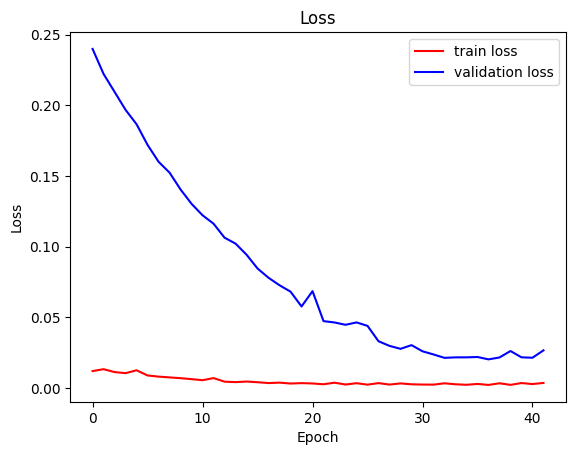

In [24]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
plt.plot(loss_history[10:], color = 'red', label = 'train loss')
plt.plot(val_loss_history[10:], color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

585/585 [==============================] - 3s 5ms/step
predicted_price shape: (18698, 2)
real_price shape: (18698, 2)


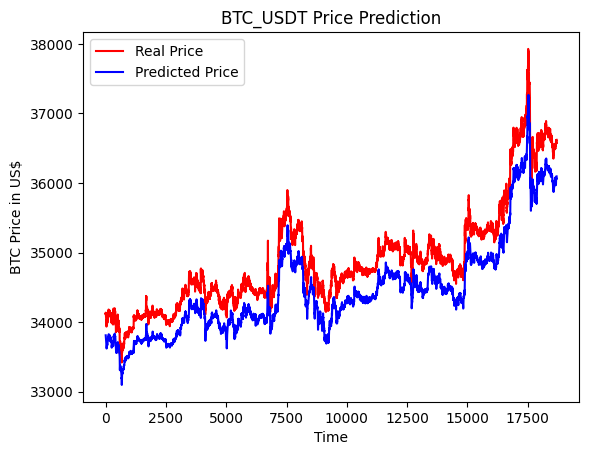

In [25]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)[:-predicting_points]
print('predicted_price shape:',predicted_price.shape)
# predicted_price

real_price = sc_target.inverse_transform(y_test)[:-predicting_points]
print('real_price shape:',real_price.shape)
# real_price

plt.plot(real_price[:,0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[:,0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

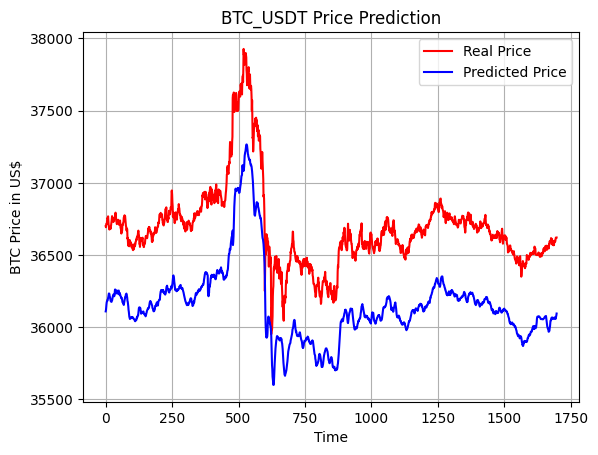

In [26]:
plt.plot(real_price[17000:, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[17000:, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.grid()
plt.show()

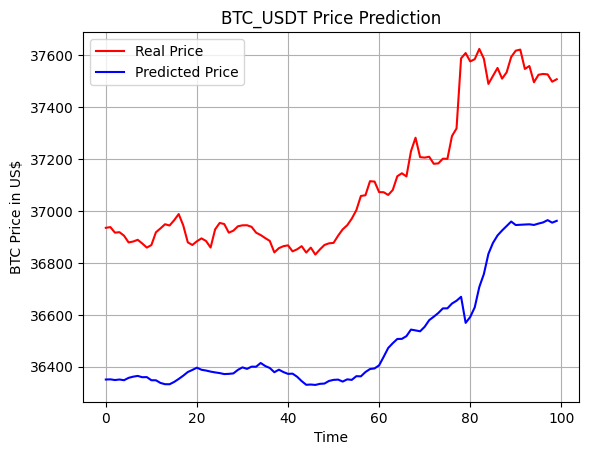

In [27]:
plt.plot(real_price[17400:17500, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[17400:17500, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.grid()
plt.show()

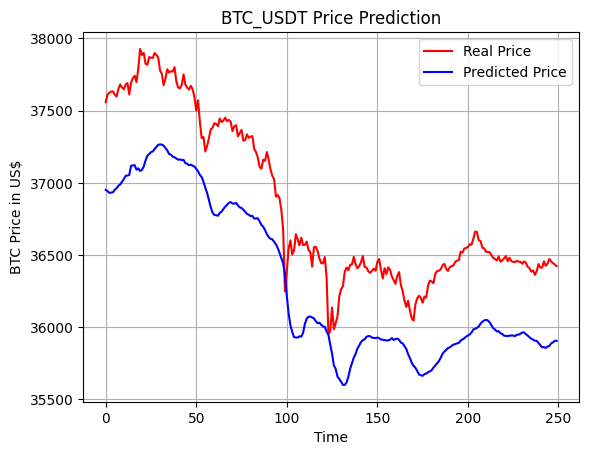

In [28]:
plt.plot(real_price[17500:17750, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[17500:17750, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.grid()
plt.show()

In [29]:
test_wmse = wmse_loss(real_price, predicted_price)
test_f1 = f1_metric(real_price, predicted_price)

print("test_wmse:",test_wmse)
print("test_f1:",float(test_f1))

test_wmse: 354458.05761433166
test_f1: 0.5081915855407715
